In [1]:
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import scipy


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Hypothesis

$H_0^j: \mathcal{I}_j(z; G) \leq \mathcal{I}_j(z; F)$ for all $z \in [0, \infty)$ ; $G$ is dominating $F$

$H_1^j: \mathcal{I}_j(z; G) >\mathcal{I}_j(z; F)$ for some $z \in [0, \infty)$ ; $G$ is not dominating $F$

Decision Rule

reject $H_0^j$ if $\hat p_j^{F,G} < \alpha$

16.146193936879445 24.59798723954897


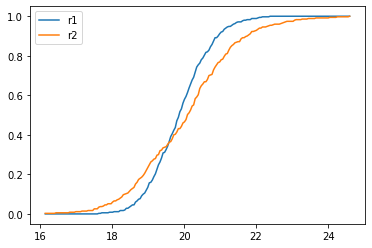

In [203]:
N = 350
M = 350
r1 = (stats.t.rvs(df=10, size=N)*0.8)+20
r2 = (stats.t.rvs(df=10, size=M)*1.2)+20
# r2 = (stats.t.rvs(df=10, size=M) + 10)
# r2 = r1

const = ((N*M/(N+M))**0.5)

n_grids = 200 # number of grid in grid search

R = 1000 # number of Monte Carlo steps

_min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
_max = np.max([np.max(r1), np.max(r2)])
income = np.linspace(_min, _max, n_grids) # grids

print(_min, _max)
ecdf1 = ECDF(r1)
ecdf2 = ECDF(r2)

plt.plot(income, ecdf1(income), label='r1')
plt.plot(income, ecdf2(income), label='r2')
plt.legend()

# test for SOSD
j = 2

In [204]:
income_N_tensor = np.repeat(income[..., None], N, 1) # repeat for sample dimension
income_N_tensor = np.repeat(income_N_tensor[..., None], R, 2) # repeat for MC dimension
# income_N_tensor[0,0,0] == income_N_tensor[0,1,0] is True 
# income_N_tensor[0,0,0] == income_N_tensor[0,0,1] is True 

income_M_tensor = np.repeat(income[..., None], M, 1)
income_M_tensor = np.repeat(income_M_tensor[..., None], R, 2)

r1_tensor = np.repeat(r1[None, ...], n_grids, 0) # repeat for grid search dimension
r1_tensor = np.repeat(r1_tensor[..., None], R, 2) # repeat for MC dimension
r1_tensor = tf.constant(r1_tensor)

r2_tensor = np.repeat(r2[None, ...], n_grids, 0)
r2_tensor = np.repeat(r2_tensor[..., None], R, 2)
r2_tensor = tf.constant(r2_tensor)

In [205]:
U1 = stats.norm.rvs(size=(N, R))
U1_tensor = tf.constant(np.repeat(U1[None, ...], n_grids, 0)) # repeat for grid search dimension

U2 = stats.norm.rvs(size=(M, R))
U2_tensor = tf.constant(np.repeat(U2[None, ...], n_grids, 0)) # repeat for grid search dimension

13.228756555322953 0.14363333775588863 1.9000904584011276


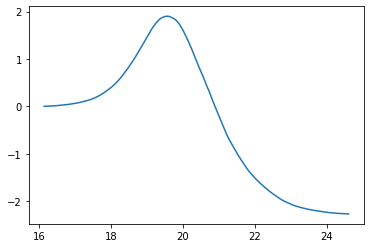

In [206]:
# Simple Numpy operation for S_hat 
def empirical_I(z, x, j):
    # x: one observation of the sample
    return (x <= z)*(z-x)**(j-1)/np.math.factorial(j-1)

def I(z, X, j):
    # Whole sample
    N = len(X)
    return 1/N*np.sum((X <= z)*(z-X)**(j-1))/np.math.factorial(j-1)

fn = lambda z: (I(z, r2, j) - I(z, r1, j))
a = np.array([fn(i) for i in income])
plt.plot(income, const*a)

S_hat = const*np.max(a)
print(const, S_hat/const, S_hat)

In [207]:
# Make functions for Numpy adapt for Tensorflow Tensor
def empirical_I_tf(z, x, j):
    # x: one observation of the sample
    return tf.cast((x <= z), tf.float64)*tf.math.add(z, -x)**(j-1)/np.math.factorial(j-1)

def I_tf(z, X, j, N):
    # Whole sample
    A = tf.cast((X <= z), tf.float64)*tf.math.add(z, -X)**(j-1)
    A = tf.math.reduce_sum(A, axis=1, keepdims=True)
    A = tf.repeat(A, N, axis=1)
    return ((1/N)*A/np.math.factorial(j-1)).numpy()

# def I_tf(z, X, j, N):
#     # Whole sample
#     A = tf.cast((X <= z), tf.float64)*tf.math.add(z, -X)**(j-1)
#     A = tf.math.reduce_mean(A, axis=1, keepdims=True)
#     A = tf.repeat(A, N, axis=1)
#     return (A/np.math.factorial(j-1)).numpy()


In [208]:
a = empirical_I_tf(income_N_tensor, r1_tensor, j)
b = I_tf(income_N_tensor, r1_tensor, j, N)

c = empirical_I_tf(income_M_tensor, r2_tensor, j)
d = I_tf(income_M_tensor, r2_tensor, j, M)

In [209]:
e = ((c-d)*U2_tensor) - ((a-b)*U1_tensor)
# e = d*U2_tensor-b*U1_tensor
# e = tf.math.reduce_sum((c-d)*U2, axis=1) - tf.math.reduce_sum((a-b)*U1, axis=1) 
const*np.mean(e)

0.007052775513536363

In [210]:
f = tf.math.reduce_sum(e, axis=1)
f.shape

TensorShape([200, 1000])

216.9874143848474


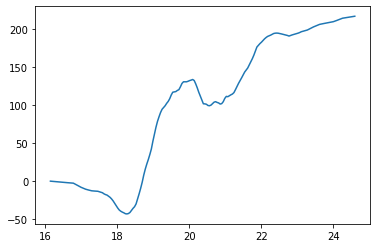

In [211]:
i=100
plt.plot(income, const*f[:,i])
print(const*np.max(f[:,i]))

In [212]:
S_bar = const*tf.math.reduce_max(f, axis=0)
S_bar.shape

TensorShape([1000])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


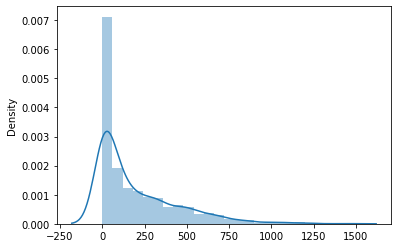

In [213]:
sns.distplot(S_bar)

$H_0^j: \mathcal{I}_j(z; G) \leq \mathcal{I}_j(z; F)$ for all $z \in [0, \infty)$ ; $G$ is dominating $F$

$H_1^j: \mathcal{I}_j(z; G) >\mathcal{I}_j(z; F)$ for some $z \in [0, \infty)$ ; $G$ is not dominating $F$


In [214]:
p = np.mean(S_bar > S_hat) 

print('P-value =', p)

if p < 0.05:
  print("Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2")
else:
  print("Cannot reject Null; r2 is domaining r1 OR r2==r1")


P-value = 0.805
Cannot reject Null; r2 is domaining r1 OR r2==r1


In [189]:
(4*R)**-0.5

0.015811388300841896

In [144]:
np.mean((c-d)*U2_tensor - (a-b)*U1_tensor)

0.0006495022619198834

In [ ]:
[np.argmax(S_bar)]

[926]

In [ ]:
S_bar.shape

TensorShape([1000])